In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
beta = 3 * np.pi / 4
gamma = np.pi / 2

In [7]:
schedules = []

In [8]:
HH = cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi)
CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[1], P0=gamma) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT.duration
# RX(beta) = U3(beta, 3*pi/2, pi/2), hence line below
RXRX = cmd_def.get('u3', qubits=[0], P0=beta, P1=3*np.pi/2, P2=np.pi/2) | cmd_def.get('u3', qubits=[1], P0=beta, P1=3*np.pi/2, P2=np.pi/2)

schedule = HH
schedule |= CNOT_RZ_CNOT << schedule.duration
schedule |= RXRX << schedule.duration
schedule |= measure << schedule.duration

schedules.append(schedule)

In [9]:
## Optimized Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
circuit = q.QuantumCircuit(2)
circuit.h(0)
circuit.h(1)
circuit.zz_interaction(gamma, 0, 1)
circuit.rx(beta, 0)
circuit.rx(beta, 1)

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


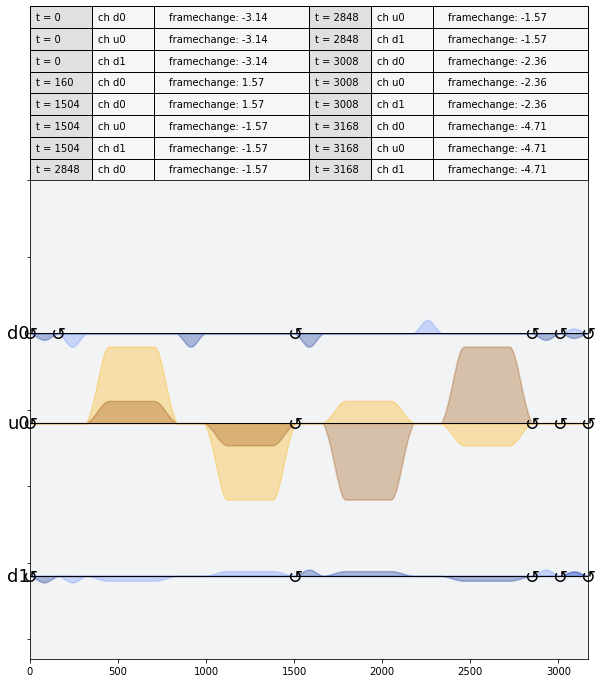

In [10]:
schedules[0].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

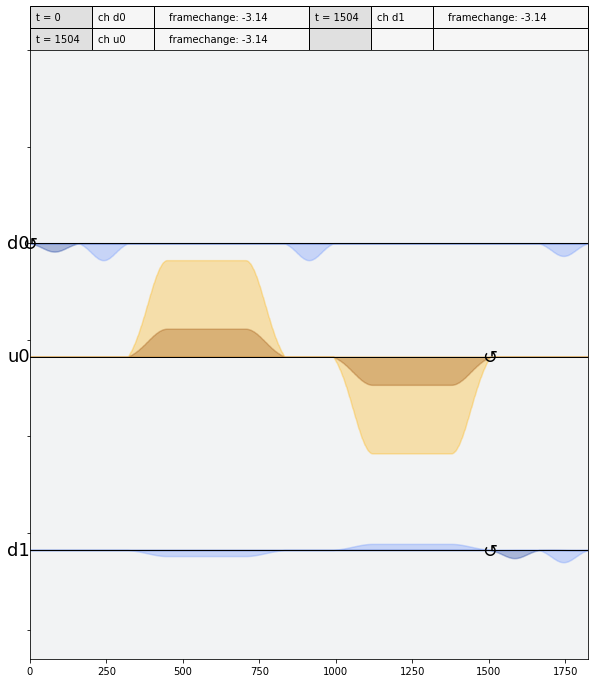

In [11]:
schedules[1].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [12]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dd99c272efcfc00184eb6f5


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [13]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

# Run a mitigation cal job

In [14]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_schedules, backend)

In [15]:
job_mit.status()

<JobStatus.VALIDATING: 'job is being validated'>

-----
## Analysis

In [16]:
from qiskit.result import marginal_counts

In [17]:
result = job.result()

In [18]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.95410156, 0.08300781, 0.08300781, 0.0078125 ],
       [0.02832031, 0.90039062, 0.00195312, 0.05371094],
       [0.01660156, 0.00195312, 0.89257812, 0.09960938],
       [0.00097656, 0.01464844, 0.02246094, 0.83886719]])

In [19]:
standard_counts = marginal_counts(result.get_counts(0), [0,1])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

before mitigation:
{'00': 584, '01': 3958, '10': 3318, '11': 140}



 after mitigation:
{'00': 9.306905529044516e-10, '01': 4340.499596429236, '10': 3659.5004035698817}


In [20]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

before mitigation:
{'00': 543, '01': 3864, '10': 3473, '11': 120}



 after mitigation:
{'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}


In [32]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [33]:
standard_counts

{'00': 0, '01': 4340, '10': 3659, '11': 0}

In [34]:
optimized_counts

{'00': 0, '01': 4201, '10': 3798, '11': 0}

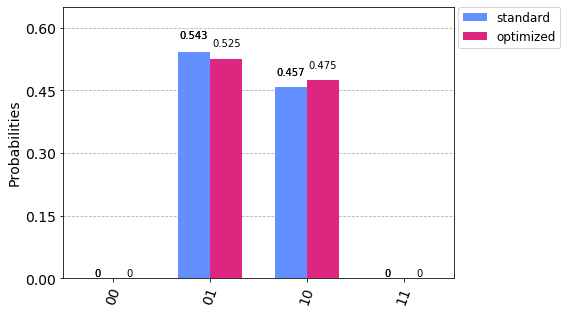

In [40]:
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [4]:
ideal_counts = {'01': 4000, '10': 4000}
standard_counts = {'00': 9.306905529044516e-10, '01': 4340.499596429236, '10': 3659.5004035698817}
optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [5]:
pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts)

0.003636315014408073

In [6]:
pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts)

0.001271382715601354